<a href="https://colab.research.google.com/github/Vafelka1/TerraAI_Vafelka/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC/Diabetical_Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отчет по 4 этапу
https://docs.google.com/document/d/1HcUfrTuy9q_YwgU6UuEUsOvTMfBggSBE36QPqMIkjRg/edit?usp=sharing

В этот раз будем строить ансамбль из 4 моделей EfficientNet с разными параметрами, размерами сети и разрешением картинки

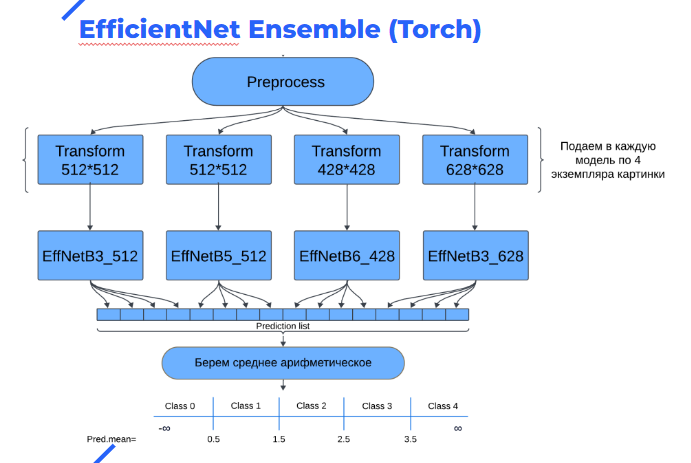

Процесс обучения всех четырех моделей представлен в этоих ноутбуках. ГРАФИКИ ОШИБОК В НОУТБУКАХ Я НЕ РИСОВАЛ, ПОЭТОМУ ОПИРАЮСЬ ТОЛЬКО НА ЧИСЛОВЫЕ ЗНАЧЕНИЯ ОШИБОК/ТОЧНОСТИ НА КАЖДОЙ ЭПОХЕ. НАДЕЮСЬ ЭТО НЕ СТОЛЬ КРИТИЧНО, Т.К ЗНАЧЕНИЕ ВСЕХ МЕТРИК В ЛЮБОМ СЛУЧАЕ ВИДНО, А ЧТОБЫ ПЕРЕРИСОВАТЬ ГРАФИКИ ПРИДЕТСЯ ЗАНОГО ТРЕНИРОВАТЬ ВСЕ МОДЕЛИ

EffNetB5 512x512 пикс https://colab.research.google.com/drive/1OyzgJ_hgKuyBvvQBlK1RKtkxSfZ-sAhu?usp=sharing

EffNetB6 428x428 пикс https://colab.research.google.com/drive/1miNZ2XWacyBQ36RzI8Vo83y9eAPViwNd?usp=sharing

EffNetB3 512x512 пикс https://colab.research.google.com/drive/1-3ztSCtqkrUKBGXR-Efd2eVgDA7krrz7?usp=sharing

EffNetB3 628x628 пикс https://colab.research.google.com/drive/18qVX4QOORiqYod8ftEgI-CBwpOzoBDgK?usp=sharing

Для тренировки модели используем датасет Kaggle2015. На мой взгляд датасет выполнен плохо, очень много недосвеченных/пересвеченных картинок, артефактов, на некоторых вообще нет снимка глаза. По примерным подсчетам от 7 до 10 процентов изображений испорчены. По идее нужно было их удалить, чтобы они не мешали, но 35000 картинок просмотреть вручную очень сложно, поэтому работаем с тем что есть

Каждая модель тренировалась примерно по 10-15 эпох (4-5часов), с батчем 20. Т.к если увеличить размер батча, нехватает 24гб памяти видеокарты

При преобработке, если глаз занимл не всю ширину картинки, я по максимуму обрезал черные зоны по краям, так чтобы на снимке остался только глаз.
https://colab.research.google.com/drive/1su-RS29N0k5J39xHUpyvld3VgrROIvVy?usp=sharing

Также при загрузке картинки нормализуются по предварительно посчитанным параметрам mean=[0.3199, 0.2240, 0.1609], std=[0.3020, 0.2183, 0.1741], а также аугментируются по контрасту,яркости,повороту + добавлен шум GausianBlur

Все модели на выходе имеют 1 нейрон, поэтому мы переводим выход в номер класса по следующему принципу:

[predictions < 0.5] = 0 класс No DR

[(predictions >= 0.5) & (predictions < 1.5)] = 1 класс Mild DR

[(predictions >= 1.5) & (predictions < 2.5)] = 2 класс Moderate RD

[(predictions >= 2.5) & (predictions < 3.5)] = 3 класс Severe Dr

[(predictions >= 3.5)]  = 4 класс Proliferative DR

# Загрузка данных

In [ ]:
import gdown
url = 'https://drive.google.com/drive/folders/1QoCcwlphHKGZMLl_s7wrRjc36_MkCtj5?usp=sharing'
gdown.download_folder(url, quiet=True)
!unzip -q '/content/Data/KaggleOnly.zip' -d '/content'

url = 'https://drive.google.com/drive/u/0/folders/1--k1r1U-URCMc9BJdFLGJuYK0AuhecX-'
gdown.download_folder(url, quiet=True)

import shutil
shutil.copy('/content/Data/trainLabels.csv', '/content/trainLabels.csv')
shutil.copy('/content/Data/valLabels.csv', '/content/valLabels.csv')
shutil.copy('/content/Data/testLabels.csv', '/content/testLabels.csv')

In [ ]:
import pandas as pd
import os
TRAIN_PATH = '/content/preprocessed/' # Папка для обучающего набора данных
NEW_TRAIN_PATH = '/content/Train/'  # Папка для перегона данных
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))
# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)
# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

In [ ]:
os.mkdir(NEW_TRAIN_PATH)
for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}{class_name}'              # Формирование полного пути к папке с изображениями класса
    new_train_path = f'{NEW_TRAIN_PATH}'                # Полный путь
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    for f in class_files:                                   # Перемещение тестовых файлов в новую папку
      os.rename(f'{class_path}/{f}', f'{new_train_path}{f}')
      #print(f'{class_path}/{f}-----{new_train_path}{f}')

# Определяем основные параметры

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
NUM_WORKERS = 6
PIN_MEMORY = True
LOAD_MODEL = True
LEARNING_RATE = 3e-5

import os
print("We are currently in the folder of ",os.getcwd())

Т.к у нас 4 нейрнных сети EfficienNet нам нужно создать несколько загрузчиков

In [ ]:
test_transforms_512 = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(0, 0), p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=True, p=1),
        A.Normalize(
            mean=[0.3199, 0.2240, 0.1609],
            std=[0.3020, 0.2183, 0.1741],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)
test_transforms_628 = A.Compose(
    [
        A.Resize(height=628, width=628),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(0, 0), p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=True, p=1),
        A.Normalize(
            mean=[0.3199, 0.2240, 0.1609],
            std=[0.3020, 0.2183, 0.1741],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)
test_transforms_428 = A.Compose(
    [
        A.Resize(height=428, width=428),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(0, 0), p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=True, p=1),
        A.Normalize(
            mean=[0.3199, 0.2240, 0.1609],
            std=[0.3020, 0.2183, 0.1741],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

Загружаем модели

In [ ]:
os.chdir('/content')
os.chdir('Models')


from efficientnet_pytorch import EfficientNet
from torch import nn
def load_models():
  EffNetB5_512_model = EfficientNet.from_name('efficientnet-b5')
  EffNetB5_512_model._fc = nn.Linear(2048, 1)

  EffNetB6_428_model = EfficientNet.from_name('efficientnet-b6')
  EffNetB6_428_model._fc = nn.Linear(2304, 1)

  EffNetB3_512_model = EfficientNet.from_name('efficientnet-b3')
  EffNetB3_512_model._fc = nn.Linear(1536, 1)

  EffNetB3_628_model = EfficientNet.from_name('efficientnet-b3')
  EffNetB3_628_model._fc = nn.Linear(1536, 1)

  EffNetB5_512_model.load_state_dict(torch.load('EffNetB5_512acc78kap78.pth.tar',map_location=torch.device('cpu'))["state_dict"])
  EffNetB6_428_model.load_state_dict(torch.load('EffNetB6_428acc77kap76.pth.tar',map_location=torch.device('cpu'))["state_dict"])
  EffNetB3_512_model.load_state_dict(torch.load('EffNetB3_512_acc79_kap76.pth.tar',map_location=torch.device('cpu'))["state_dict"])
  EffNetB3_628_model.load_state_dict(torch.load('EffNetB3_628_acc79_kap72.pth.tar',map_location=torch.device('cpu'))["state_dict"])

  EffNetB5_512_model.eval()
  EffNetB6_428_model.eval()
  EffNetB3_512_model.eval()
  EffNetB3_628_model.eval()

In [ ]:
os.chdir('/content')

Функция предикта для картинки, здесь будут учавствовать все 4 модели. Каждая картинка будет 4 раза подаваться в каждую модель, с небольшой аугментацией по яркости,контрасту и повороту. Итого получиться 16 предиктов, мы считаем средний предикт и берем его как выход.

In [ ]:
def predict_img_ensamble(path):
  x = np.array(Image.open(path))
  predict = []

  #512 models
  for i in range(4):
    image = test_transforms_512(image=x)["image"]
    image = image.unsqueeze(0)
    with torch.no_grad():
      pred = EffNetB5_512_model(image)
      predict.append(pred)
      pred = EffNetB3_512_model(image)
      predict.append(pred)

  #428 model
  for i in range(4):
    image = test_transforms_428(image=x)["image"]
    image = image.unsqueeze(0)
    with torch.no_grad():
      pred = EffNetB6_428_model(image)
      predict.append(pred)

  #628 model
  for i in range(4):
    image = test_transforms_628(image=x)["image"]
    image = image.unsqueeze(0)
    with torch.no_grad():
      pred = EffNetB3_628_model(image)
      predict.append(pred)

  predict = np.squeeze(np.array(predict),(-1,-2))

  mean_predict = predict.mean()

  if mean_predict < 0.5: predict = 0
  elif mean_predict >= 0.5 and mean_predict < 1.5: predict = 1
  elif mean_predict >= 1.5 and mean_predict < 2.5: predict = 2
  elif mean_predict >= 2.5 and mean_predict < 3.5: predict = 3
  elif mean_predict >= 3.5: predict = 4

  return(predict)


# Делаем evaluate на тестовых данных (~3600 картинок)

In [ ]:
import pandas as pd

In [ ]:
def evaluate(test_df,dir_path):
  ev_preds=[]
  count=0
  df = pd.read_csv(test_df)
  for i in tqdm(range(df.shape[0])):
  #for i in tqdm(range(200)):
    image_file, label = df.iloc[i]
    image_file=image_file+".jpeg"
    image_path = dir_path+'/'+image_file
    pred = predict_img_ensamble(image_path)
    ev_preds.append(pred)
    if pred == label: count+=1

  return count,ev_preds


In [ ]:
count,ev_preds = evaluate('testLabels.csv','Train')

100%|████████████████████████████████████████████████████████████████████████████| 3162/3162 [7:50:01<00:00,  8.92s/it]


In [ ]:
import pickle
with open('count.pickle', 'wb') as f:
    pickle.dump(count, f)
with open('ev_preds.pickle', 'wb') as f:
    pickle.dump(ev_preds, f)

In [ ]:
print(f'Accuracy: -- {round(count/3162,5)}')

Accuracy: -- 0.80898


In [ ]:
import pickle
with open('/content/ev_preds.pickle', 'rb') as f:
    ev_preds = pickle.load(f)

In [ ]:
from sklearn.metrics import cohen_kappa_score
df = pd.read_csv('testLabels.csv')
ev_true = np.array(df['diagnosis'])

In [ ]:
ev_preds = np.array(ev_preds)

In [ ]:
kappa = cohen_kappa_score(ev_true, ev_preds, weights='quadratic')
print(f"QuadraticWeightedKappa: {round(kappa,5)}")

QuadraticWeightedKappa: 0.78359


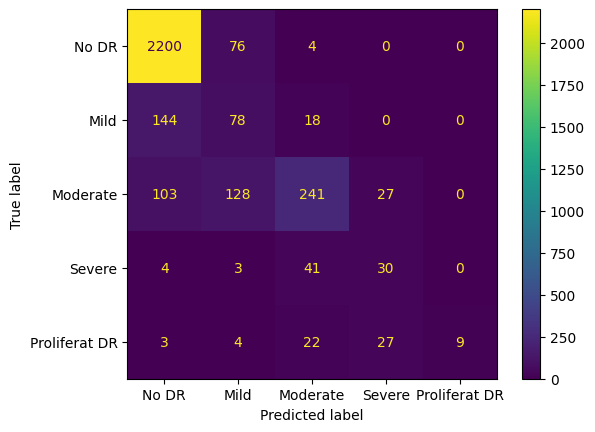

In [ ]:
labels=["No DR","Mild","Moderate","Severe","Proliferat DR"]
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cf = confusion_matrix(ev_true, ev_preds)
disp = ConfusionMatrixDisplay(cf,display_labels=labels)
disp.plot()
plt.show()

# Выводы

Точность по сетям QWKappa на валидационных данных:

EffNetB5_512 - 78 val

EffNetB6_428 - 75 val

EffNetB3_512 - 75 val

EffNetB3_628 - 72 val

Модель B5 показала наилучшие результаты. Но на тестовых данных точность каждой сети падала на 3-4%, поэтому решил сделать из них ансамбль. В итоге ансамбль отрабатывает на 78.4% на тестовых данных

Т.к наличие/стадия заболевания не являются измеряемой величиной и определяются врачами "на глаз", в датасете много спорных меток. Один и тот же снимок разные врачи могут отнести как во 2ой, так и в 3й класс. Поэтому в соревновании точность считается именно по метрике WheightedKappa, которая у нас составляет 78.4% (В топ 15 среди участников). Она учитывыет не только правильно ли был определен класс, но и то насколько предикт, близок к лейблу. То есть для картинки из 4 класса сеть выдает лейбл 1, то ошибка будет сильно больше,чем если бы сеть выдала лейбл 3.

Максимальный результат достигнутый на этом датасете среди всех участвующик был 84.9% (Тоже ансамбль). Возможно если поиграться с выводами моделей или преобработкой, можно добавить 3-5 процента к точности (перевод в grayscale делает только хуже), но обучение на таком датасете тратит очень много времени и ресурсов, поэтому остановлюсь на достигнутом результате. А также я уже упоминал, что датасет очень "грязный" и с таким количеством мусорных картинок добыиться 90% точности  совершенно невозможно. Я подобрался достаточно близко к победителю, поэтому считаю работу выполненной.

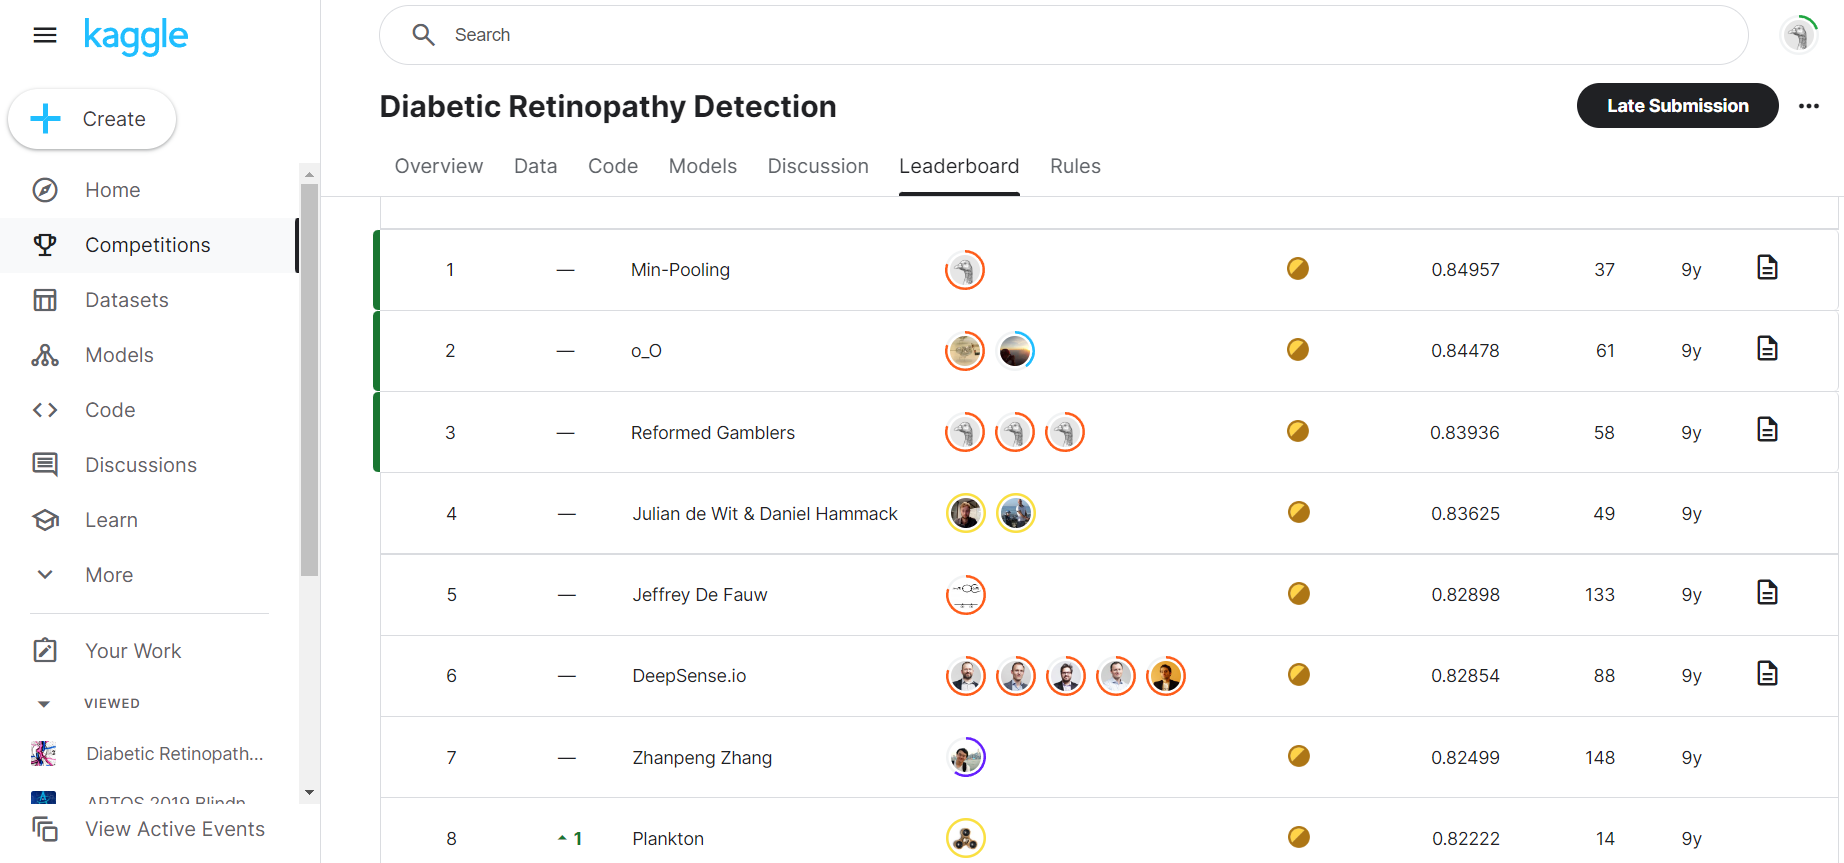